In [1]:
import sys
sys.path.insert(0, '../')
from util import util_data_access

In [2]:
# download data
util_data_access.download_file('newssniffer-nytimes.db.gz', 'edit-pathways/dbs/newssniffer-nytimes.db.gz')
! gunzip newssniffer-nytimes.db.gz

In [3]:
# util_data_access.download_file('glove-100d-loc.tar.gz', 'spark-nlp/glove-100d-loc.tar.gz')
# ! tar -xzvf glove-100d-loc.tar.gz 

# Load Spark

In [4]:
from pyspark.sql import SparkSession
# spark = sparknlp.start()

spark = (
    SparkSession.builder
      .config("spark.executor.instances", "30")
      .config("spark.driver.memory", "20g")
      .config("spark.executor.memory", "20g")
      .config("spark.sql.shuffle.partitions", "1000")
      .config("spark.executor.cores", "5")
      .config("spark.kryoserializer.buffer.max", "2000M")
      .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.11:2.7.5")
      .getOrCreate()
)

In [5]:
spark

# Load Our Own Data

In [10]:
import sqlite3
import pandas as pd
from tqdm.auto import tqdm
import pyspark.sql.functions as F
# import unidecode

# conn = sqlite3.connect('../data/diffengine-diffs/db/newssniffer-nytimes.db')
with sqlite3.connect('newssniffer-nytimes.db') as conn:

    # df = pd.read_sql('''
    #      SELECT * from entryversion 
    #      WHERE entry_id IN (SELECT distinct entry_id FROM entryversion LIMIT 2)
    #  ''', con=conn)

    df = pd.read_sql('''
         SELECT * from entryversion 
         WHERE entry_id IN (1951413, 1952324)
     ''', con=conn)
    # , 1969148, 1451793, 1938021
    df = df.assign(summary=lambda df: df['summary'].str.replace('</p><p>', ' '))

In [11]:
sdf = spark.createDataFrame(df)

# With Sentences

In [12]:
from pyspark.ml.feature import Normalizer, SQLTransformer
from pyspark.ml.feature import BucketedRandomProjectionLSH
from scipy.spatial import distance
from pyspark.sql.types import FloatType
from scipy.spatial import distance
import sparknlp.base as sb
import sparknlp.annotator as sa

In [13]:
documenter = (
    sb.DocumentAssembler()
        .setInputCol("summary")
        .setOutputCol("document")
)

sentencer = (
    sa.SentenceDetector()
        .setInputCols(["document"])
        .setOutputCol("sentences")            
)

tokenizer = (
    sa.Tokenizer()
        .setInputCols(["sentences"])
        .setOutputCol("token")
)

word_embeddings = (
    sa.BertEmbeddings
        .load('s3://aspangher/spark-nlp/small_bert_L4_128_en_2.6.0_2.4')
        .setInputCols(["sentences", "token"])
        .setOutputCol("embeddings")
        .setMaxSentenceLength(512)
        .setBatchSize(100)
)

In [14]:
tok_finisher = (
    sb.Finisher()
    .setInputCols(["token"])
    .setIncludeMetadata(True)
)

embeddings_finisher = (
    sb.EmbeddingsFinisher()
            .setInputCols("embeddings")
            .setOutputCols("embeddings_vectors")
            .setOutputAsVector(True)
)

In [15]:
zip_tok = (
    SQLTransformer()
     .setStatement("""
         SELECT CAST(entry_id AS int) as entry_id,
                CAST(version AS int) as version, 
                ARRAYS_ZIP(finished_token, finished_token_metadata, embeddings_vectors) AS zipped_tokens
         FROM __THIS__
    """)
)

explode_tok = (
    SQLTransformer()
     .setStatement("""
         SELECT entry_id, version, POSEXPLODE(zipped_tokens) AS (word_idx, zipped_token)
         FROM __THIS__
    """)
)

rename_tok = (
    SQLTransformer()
     .setStatement("""
         SELECT entry_id, 
                 version,
                 CAST(zipped_token.finished_token_metadata._2 AS int) AS sent_idx,
                 COUNT(1) OVER(PARTITION BY entry_id, version, zipped_token.finished_token_metadata._2) as num_words,
                 CAST(word_idx AS int) word_idx,
                 zipped_token.finished_token AS token,
                 zipped_token.embeddings_vectors as word_embedding
         FROM __THIS__
    """)
) 

vector_normalizer = (
    Normalizer(
        inputCol="word_embedding", 
        outputCol="norm_word_embedding", 
        p=2.0
    )
)
similarty_checker = (
    BucketedRandomProjectionLSH(
        inputCol="norm_word_embedding", 
        outputCol="hashes", 
        bucketLength=6.0, 
        numHashTables=6
    )
)

def cosine_distance(x, y):
    return float(distance.cosine(x, y))
spark.udf.register("cosine_distance", cosine_distance, "float")

inner_join = (
    SQLTransformer()
     .setStatement("""
         SELECT word_emb.entry_id                                                    AS entry_id, 
                 word_emb.version                                                    AS version_x,
                 word_emb_2.version                                                  AS version_y,
                 word_emb.sent_idx                                                   AS sent_idx_x,
                 word_emb_2.sent_idx                                                 AS sent_idx_y,
                 word_emb.num_words                                                  AS num_words_x,
                 word_emb.word_idx                                                   AS word_idx_x,
                 word_emb_2.word_idx                                                 AS word_idx_y,
                 word_emb.token                                                      AS token_x,
                 word_emb_2.token                                                    AS token_y,
                 cosine_distance(word_emb.word_embedding, word_emb_2.word_embedding) AS cosine_distance
         FROM __THIS__ word_emb
         JOIN __THIS__ word_emb_2
         ON word_emb.entry_id = word_emb_2.entry_id and
         word_emb.version + 1 = word_emb_2.version
    """)
)

In [71]:
def get_word_matching_sql(side):
    """Generate the SQL necessary to transform each side. Side \in {'x', 'y'}"""
    
    word_pair_min_distance_sql = """
         SELECT entry_id,
                version_x,
                version_y,
                sent_idx_x,
                sent_idx_y,
                word_idx_%(side)s,
                MIN(num_words) as num_words_total_list,
                MIN(distance) as min_word_distance
        FROM __THIS__ 
        GROUP BY entry_id,
                version_x,
                version_y,
                sent_idx_x,
                sent_idx_y,
                word_idx_%(side)s
      """ % ({'side': side})
    
    sentence_pair_min_distance_sql = """
        SELECT entry_id,
               version_x,
               version_y,
               sent_idx_x,
               sent_idx_y,
               (sum_min_word_distance + .5 * ( num_words_total - num_matched_words )) / num_words_total AS avg_sentence_distance
        FROM (
           SELECT entry_id,
                  version_x,
                  version_y,
                  sent_idx_x,
                  sent_idx_y,
                  SUM(min_word_distance) AS sum_min_word_distance,
                  COUNT(1) AS num_matched_words,
                  MIN(num_words_total_list) AS num_words_total
           FROM __THIS__
                GROUP BY entry_id,
                   version_x,
                   version_y,
                   sent_idx_x,
                   sent_idx_y
          )
      """
    
    sentence_min_sql = """
         SELECT entry_id,
                version_x,
                version_y,
                sent_idx_x,
                sent_idx_y,
                avg_sentence_distance
           FROM (
                    SELECT *, ROW_NUMBER() OVER (
                         PARTITION BY entry_id, 
                                      version_x, 
                                      version_y, 
                                      sent_idx_%(side)s
                         ORDER BY avg_sentence_distance ASC
                ) AS rn FROM __THIS__
        )
         where rn = 1
    """ % ({'side': side})
    
    threshold_sql = """
         SELECT entry_id,
                version_x,
                version_y,
                sent_idx_%(join_side)s,
                CASE 
                    WHEN (avg_sentence_distance < .44 ) THEN sent_idx_%(other_side)s
                    ELSE NULL
                END AS sent_idx_%(other_side)s,
                CASE 
                    WHEN (avg_sentence_distance < .44 ) THEN avg_sentence_distance
                    ELSE NULL
                END AS avg_sentence_distance
            FROM __THIS__
    """ %({'join_side': side, 'other_side': list({'x', 'y'} - set(side))[0]})
    
    return word_pair_min_distance_sql, sentence_pair_min_distance_sql, sentence_min_sql, threshold_sql

In [83]:
sparknlp_processing_pipeline = sb.RecursivePipeline(stages=[
    documenter,
    sentencer,
    tokenizer,
    word_embeddings,
    embeddings_finisher,
    tok_finisher
  ]
)

explode_pipeline = sb.PipelineModel(stages=[
    zip_tok,
    explode_tok,
    rename_tok,
])

similarity_pipeline = sb.Pipeline(stages=[
    vector_normalizer,
    similarty_checker
])

In [103]:
## init pipeline and cache
init_sdf = sparknlp_processing_pipeline.fit(sdf).transform(sdf)
init_sdf = init_sdf.cache()

In [87]:
t = init_sdf.toPandas() ## 5s, no memory swapped

In [102]:
exploded_sdf = explode_pipeline.transform(init_sdf)
exploded_sdf = exploded_sdf.cache()
t2 = exploded_sdf.toPandas() ## 5s, 63 MB swapped

In [101]:
similarity_model = similarity_pipeline.fit(exploded_sdf)
sim_sdf = similarity_model.transform(exploded_sdf)

In [119]:
sim_sdf = sim_sdf.repartition(
    'entry_id',
    'version',
#     'sent_idx',
#     'word_idx',
).cache()

## with 1000 partitions:
## -----------------------------------------------------------------------------------
## without version repartition, next step swaps 	1677.2 MB	1865.6 MB
## without sent_idx repartition, next step swaps 1673.8 MB	1865.6 MB
## without word_idx repartition, next step swaps 	1677.2 MB	1865.6 MB memory
## with word_idx repartition, next step swaps 	1768.6 MB	1865.6 MB

In [117]:
## Approximate Join
word_pair_matched_sdf = (
    similarity_model
    .stages[1]
    .approxSimilarityJoin(sim_sdf, sim_sdf, .5, distCol="distance")
    .where((F.col("datasetA.entry_id") == F.col("datasetB.entry_id")) & (F.col("datasetA.version") + 1 == F.col("datasetB.version")))
    .select(
         F.col("datasetA.entry_id").alias("entry_id"),
         F.col("datasetA.version").alias("version_x"),
         F.col("datasetB.version").alias("version_y"),
         F.col("datasetA.sent_idx").alias("sent_idx_x"),
         F.col("datasetB.sent_idx").alias("sent_idx_y"),        
         F.col("datasetA.word_idx").alias("word_idx_x"),
         F.col("datasetB.word_idx").alias("word_idx_y"),
         F.col("datasetA.num_words").alias("num_words"),
         F.col("datasetA.token").alias("token_x"),
         F.col("datasetB.token").alias("token_y"),
         F.col("distance")
    )
)

In [118]:
t = word_pair_matched_sdf.toPandas()

In [70]:
word_pair_matched_sdf = word_pair_matched_sdf.repartition(
                        'entry_id',
                        'version_x',
                        'version_y',
                        'sent_idx_x',
                        'sent_idx_y',
#                         word_idx_x
#                         word_idx_y
).cache()

In [72]:
## get top sentences, X
s1x, s2x, s3x, s4x = get_word_matching_sql(side='x')
get_word_pair_min_distance_x = SQLTransformer().setStatement(s1x)
get_sentence_min_distance_x = SQLTransformer().setStatement(s2x)
get_min_sentence_x = SQLTransformer().setStatement(s3x)
threshold_x = SQLTransformer().setStatement(s4x)

top_sentence_pipeline_x = sb.PipelineModel(stages=[
    get_word_pair_min_distance_x,
    get_sentence_min_distance_x,
    get_min_sentence_x,
    threshold_x
])

## get top sentences, Y
s1y, s2y, s3y, s4y = get_word_matching_sql(side='y')
get_word_pair_min_distance_y = SQLTransformer().setStatement(s1y)
get_sentence_min_distance_y = SQLTransformer().setStatement(s2y)
get_min_sentence_y = SQLTransformer().setStatement(s3y)
threshold_y = SQLTransformer().setStatement(s4y)

## get top sentences
top_sentence_pipeline_y = sb.PipelineModel(stages=[
    get_word_pair_min_distance_y,
    get_sentence_min_distance_y,
    get_min_sentence_y,
    threshold_y
])

In [73]:
sent_pairs_x_sdf = top_sentence_pipeline_x.transform(word_pair_matched_sdf).cache()
sent_pairs_y_sdf = top_sentence_pipeline_y.transform(word_pair_matched_sdf).cache()

In [74]:
join_cols=['entry_id', 'version_x', 'version_y', 'sent_idx_x', 'sent_idx_y']
final_sdf = sent_pairs_x_sdf.withColumn('avg_sentence_distance_x', F.col('avg_sentence_distance')).join(
    sent_pairs_y_sdf.withColumn('avg_sentence_distance_y', F.col('avg_sentence_distance')),
    on=join_cols, 
    how='outer'
).dropDuplicates(join_cols)

In [75]:
final_df = final_sdf.toPandas()

In [68]:
final_df

,entry_id,version_x,version_y,sent_idx_x,sent_idx_y,avg_sentence_distance,avg_sentence_distance_x,avg_sentence_distance,avg_sentence_distance_y
0,1952324,13,14,80.0,78.0,3.021371e-07,3.021371e-07,3.021371e-07,3.021371e-07
1,1952324,5,6,47.0,47.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2,1951413,17,18,27.0,27.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
3,1951413,5,6,15.0,15.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
4,1951413,5,6,35.0,38.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
5,1951413,4,5,14.0,14.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
6,1951413,7,8,90.0,93.0,1.854937e-09,1.854937e-09,1.854937e-09,1.854937e-09
7,1952324,3,4,9.0,28.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
8,1952324,9,10,NaN,78.0,NaN,NaN,NaN,NaN
9,1951413,2,3,NaN,33.0,NaN,NaN,NaN,NaN


In [50]:
sent_pairs_x.shape

(3197, 6)

In [119]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(spark.sparkContext)

In [ ]:
explode_sent = (
    SQLTransformer()
     .setStatement("""
         SELECT entry_id, version, sent_idx 
         FROM (
             SELECT entry_id, version, POSEXPLODE(sentences) AS (sent_idx, sentence)
             FROM __THIS__
         )
    """)
)
sent_idx_sdf = explode_sent.transform(init_sdf)

In [126]:
min_sent_df_x.registerTempTable("matchedSentencesX")

In [125]:
sent_idx_sdf.registerTempTable("Sentences")

In [ ]:
missing_y_df = sqlContext.sql("""
    SELECT entry_id, version, full_sent_idx as unmatched_sent_idx
    FROM (
        SELECT s.entry_id as entry_id, 
               s.version AS version, 
               s.sent_idx as full_sent_idx,
               m.sent_idx_y as matched_sent_idx
        FROM matchedSentencesX m
        FULL OUTER JOIN Sentences s
        ON s.entry_id = m.entry_id
        AND s.version = m.version_y
        AND s.sent_idx = m.sent_idx_y
    ) where matched_sent_idx is NULL
""").toPandas()

In [ ]:
temp_df

In [127]:
min_sent_dfp.merge(sent_idx_sdfp, 
                   left_on=['entry_id', 'version_y',  'sent_idx_y'],
                   right_on=['entry_id', 'version', 'sent_idx'],
                   how='right'
                  ).loc[lambda df: df['sent_idx_y'].isnull()]

,entry_id,version_x,version_y,sent_idx_x,sent_idx_y,avg_sentence_distance,version,sent_idx
10128,1451793,NaN,NaN,NaN,NaN,NaN,0,0
10129,1451793,NaN,NaN,NaN,NaN,NaN,0,1
10130,1451793,NaN,NaN,NaN,NaN,NaN,0,2
10131,1451793,NaN,NaN,NaN,NaN,NaN,0,3
10132,1451793,NaN,NaN,NaN,NaN,NaN,0,4
10133,1451793,NaN,NaN,NaN,NaN,NaN,0,5
10134,1451793,NaN,NaN,NaN,NaN,NaN,0,6
10135,1451793,NaN,NaN,NaN,NaN,NaN,0,7
10136,1451793,NaN,NaN,NaN,NaN,NaN,0,8
10137,1451793,NaN,NaN,NaN,NaN,NaN,0,9


In [ ]:
get_missing_y = (
    SQLTransformer()
        .set_statement("""
            SELECT entry_id,
                version_y,
                sent_idx_y
        
        """)
)

In [ ]:
y_matches = sb.PipelineModel(stages=[
])

In [123]:
min_sent_df_x = top_sentence_pipeline_x.transform(joined_df)
# min_sent_dfp = min_sent_df.toPandas()

In [108]:
sent_idx_sdfp = sent_idx_sdf.toPandas()

In [109]:
sent_idx_sdfp.head()

,entry_id,version,sent_idx
0,1451793,0,0
1,1451793,0,1
2,1451793,0,2
3,1451793,0,3
4,1451793,0,4


In [112]:
sent_idx_sdfp.shape

(10936, 3)

In [48]:
## todo:
## -----------------------------------------------------------------------------------------------------------------
## 1. Determine mapping cutoff to differentiate similar and dissimilar sentences (probably .4)
##
## 2. Implement algorithm:
## 
## a. for all x with distance > .4, drop y
## b. for all y without a label, do the sentence match in reverse
## c. for all y with a distance > .4, drop x

In [56]:
import numpy as np 

In [ ]:
(min_sent_dfp
 .assign(sent_idx_y = lambda df: df.apply(lambda x: x['sent_idx_y'] if x['avg_sentence_distance'] < .44 else np.nan, axis=1))
)

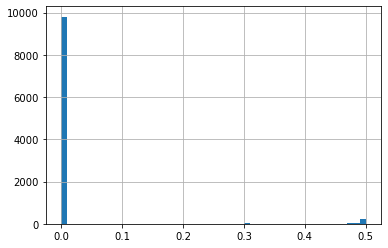

In [28]:
min_sent_dfp['avg_sentence_distance'].hist(bins=50)

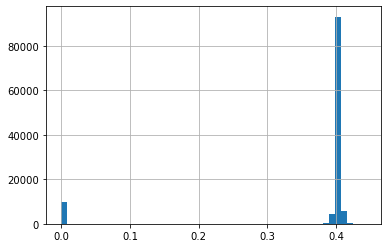

In [422]:
min_sent_dfp['avg_sentence_distance'].hist(bins=50)#, range=(0, 20))

In [428]:
min_sent_dfp = min_sent_dfp.sort_values(['entry_id', 'version_x', 'version_y', 'sent_idx_x', 'sent_idx_y'])

# Get Sentences for Inspection

In [31]:
normer = (
    sa.DocumentNormalizer()
    .setInputCols(["document"])
    .setOutputCol("normed_document")
    .setPatterns(["[^\w\d\s\.\,\"\']"])
#     .setPolicy('pretty_all')
)

sentencer = (
    sa.SentenceDetector()
        .setInputCols(["document"])
        .setOutputCol("sentences")            
)

# sentencer_dl = (
#     sa.SentenceDetectorDLModel
#         .load('s3://aspangher/spark-nlp/sentence_detector_dl_en')
#         .setInputCols(["document"])
#         .setOutputCol("sentences")            
# )

sent_finisher = (
    sb.Finisher()
    .setInputCols(["sentences"])
)

explode_sent = (
    SQLTransformer()
     .setStatement("""
         SELECT entry_id, version, POSEXPLODE(finished_sentences) AS (sent_idx, sentence)
         FROM __THIS__
    """)
)

sentence_splitter_pipeline = sb.RecursivePipeline(stages=[
    documenter,
    sentencer,
    sent_finisher,
    explode_sent
])

In [32]:
sent_dfp = sentence_splitter_pipeline.fit(sdf).transform(sdf).toPandas()

In [33]:
min_sent_dfp[['entry_id', 'version_x', 'version_y']].drop_duplicates().head(10)

,entry_id,version_x,version_y
0,1451793,2,3
2,1451793,4,5
3,1451793,6,7
5,1451793,7,8
6,1451793,9,10
7,1451793,11,12
9,1451793,15,16
11,1451793,18,19
12,1451793,22,23
13,1451793,24,25


# Compare Sentences

In [36]:
from IPython.display import display, HTML
import sys
sys.path.append('..')
## download spacy model 
# download data
from util import util_data_access
import os
if not os.path.exists('en_core_web_lg'):
    util_data_access.download_file('en_core_web_lg.tar.gz', 'edit-pathways/spacy/en_core_web_lg.tar.gz')
    ! tar -xf en_core_web_lg.tar.gz
    ! mv en_core_web_lg-2.3.1 en_core_web_lg
import util.util_newssniffer_parsing as unp

In [43]:
comp_sents = (min_sent_dfp
 .loc[lambda df: df['entry_id'] == 1451793]
 .loc[lambda df: df['version_x'] == 3]
 .loc[lambda df: df['version_y'] == 4]
 .merge(
    sent_dfp,
    left_on=['entry_id', 'version_x', 'sent_idx_x'],
    right_on=['entry_id', 'version', 'sent_idx'],
    how='left'
 ).drop(['version', 'sent_idx',], axis=1)
 .merge(
    sent_dfp, 
    left_on=['entry_id', 'version_y', 'sent_idx_y'],
    right_on=['entry_id', 'version', 'sent_idx'],
    how='left'
 )
 .drop(['version', 'sent_idx',], axis=1)
 .sort_values(['sent_idx_x', 'sent_idx_y'])
)

In [52]:
html = [
    '<table>',
    '<tr><th>SIdx Old</th><th>Old Version</th><th>New Version</th><th>SIdx New</th><th>Distance</th></tr>',
]
for s_idx_1, s_idx_2, s1, s2, d in (
        comp_sents
            [['sent_idx_x', 'sent_idx_y', 'sentence_x', 'sentence_y', 'avg_sentence_distance']]
            .loc[lambda df: df['avg_sentence_distance'] > .44]
            .itertuples(index=False)
):
    one_row = '<tr><td>%s</td><td>%s</td><td>%s</td><td>%s</td><td>%s</td></tr>'
    w1, w2 = unp.get_words(s1), unp.get_words(s2)
    hs1, hs2 = unp.html_compare_sentences(*unp.get_list_diff(w1, w2))
    html.append(one_row % (s_idx_1, hs1, hs2, s_idx_2, d))
    
html_output = ''.join(html).replace('$', r'\$')

In [53]:
display(HTML(html_output))

SIdx Old,Old Version,New Version,SIdx New,Distance
8,Gov.,• Gov.,18,0.4353618860719247
15,"In Cuba , where the storm lingered for some 24 hours , President Raúl Castro said there had been serious damage to the power grid across the country .",President Raúl Castro said there had been serious damage to the country ’s power grid .,12,0.4192641570182649
17,"• In addition to the Florida evacuations , 540,000 people were told to leave the Georgia coast .","About 540,000 people were told to leave the Georgia coast .",15,0.44576459729955076
26,"Starting on Saturday morning , lines that were several blocks long formed outside shelters such as the Germain Arena , as residents jammed inside .","In Miami - Dade County , some people who had flocked to shelters were reassessing their situation on Saturday afternoon after learning that the brunt of the hurricane would most likely be felt farther west .",55,0.49502140840691206
27,"In Fort Myers , which is in Lee County , buses that were taking people to shelters stopped running at 3 p.m. to allow the drivers to seek safety , potentially stranding people who had not left their homes in time .","In Miami - Dade County , some people who had flocked to shelters were reassessing their situation on Saturday afternoon after learning that the brunt of the hurricane would most likely be felt farther west .",55,0.49724064565173226
28,"Late Saturday afternoon , all the shelters in Collier County were at capacity , according to local news reports .","In Miami - Dade County , some people who had flocked to shelters were reassessing their situation on Saturday afternoon after learning that the brunt of the hurricane would most likely be felt farther west .",55,0.49191399219260123
29,"Because of the imminent storm surge , officials told people living in one - story homes to try to enter shelters anyway , and people in two - story homes to seek shelter upstairs .",It ’s going to take us a while to get back in there to try to provide services .,74,0.49586038790318115
35,"” Inside , dozens of people lay on cots and blankets in the building ’s hallways amid a stench of perspiration and vomit .","” In the Florida Keys , emergency officials girded for a direct hit and residents who did not evacuate began to take cover as the winds kicked up sharply Saturday afternoon .",64,0.49978103409167535
36,Some were packing to leave but most seemed resigned to remaining until the storm blew through .,"At 6 a.m. , Collier County declared a civil emergency and ordered all residents to shelter in place until the storm passed .",50,0.489619965191293
37,"As Hurricane Irma steered its way toward the Florida Keys on Saturday night , Florida began to feel its approach .","Packing winds of 130 miles per hour , Hurricane Irma ’s eye began passing over the Florida Keys on Sunday morning after leaving a path of destruction across the Caribbean .",0,0.48800947660994254


# Test if the approximation is the same as the full inner join

In [ ]:
min_dist_inner_join = word_emb_sdfp.groupby([
    'entry_id',
    'version_x',
    'version_y',
    'sent_idx_x',
    'sent_idx_y',
    'word_idx_x',
    'token_x',
])['cosine_distance'].min()

min_dist_inner_join.shape

min_dist_approx = joined_dfp.groupby([
    'entry_id',
    'version_x',
    'version_y',
    'sent_idx_x',
    'sent_idx_y',
    'word_idx_x',
    'num_words',
    'token_x',
])['distance'].min()

joined_dfp[['entry_id', 'version_x', 'version_y', 'sent_idx_x', 'sent_idx_y', 'num_words']].drop_duplicates()['num_words'].sum()

min_full = (word_emb_sdfp
 ## get max words
 .loc[lambda df: df.groupby(['entry_id', 'version_x', 'sent_idx_x', 'sent_idx_y', 'word_idx_x', 'token_x'])['cosine_distance'].idxmin()]#[des_col_list]
 ## get mean of sentence
 .groupby(['entry_id', 'version_x', 'sent_idx_x', 'version_y', 'sent_idx_y'])['cosine_distance'].mean().reset_index()
 ## get max sentence
 .loc[lambda df: df.groupby(['entry_id', 'version_x', 'sent_idx_x', 'version_y'])['cosine_distance'].idxmin()]
)

min_approx = (joined_dfp
 ## get max words
 .loc[lambda df: df.groupby(['entry_id', 'version_x', 'sent_idx_x', 'sent_idx_y', 'word_idx_x', 'token_x'])['distance'].idxmin()]#[des_col_list]
 ## get mean of sentence
 .groupby(['entry_id', 'version_x', 'sent_idx_x', 'version_y', 'sent_idx_y'])['distance'].mean().reset_index()
 ## get max sentence
 .loc[lambda df: df.groupby(['entry_id', 'version_x', 'sent_idx_x', 'version_y'])['distance'].idxmin()]
)

(min_full.sort_values(['entry_id', 'version_x', 'version_y', 'sent_idx_x', 'sent_idx_y'])['sent_idx_x'].values
== min_approx.sort_values(['entry_id', 'version_x', 'version_y', 'sent_idx_x', 'sent_idx_y'])['sent_idx_x'].values)

(min_full.sort_values(['entry_id', 'version_x', 'version_y', 'sent_idx_x', 'sent_idx_y'])['sent_idx_y'].values
== min_approx.sort_values(['entry_id', 'version_x', 'version_y', 'sent_idx_x', 'sent_idx_y'])['sent_idx_y'].values)

In [34]:
word_emb_sdf = word_emb_sdf.cache()

In [ ]:
word_emb_sdf = word_emb_sdf.repartition('entry_id', 'version_x', 'version_y', 'sent_idx_x', 'sent_idx_y')#, 'word_idx_x')

In [ ]:
word_emb_sdf.show()

In [17]:
word_emb_sdf = get_max_word_min.transform(word_emb_sdf)

In [21]:
from pyspark.sql.functions import spark_partition_id, asc, desc
partitions = (
    word_emb_sdf
        .withColumn("partitionId", spark_partition_id())
        .groupBy("partitionId")
        .count()
        .orderBy(asc("count"))
        .toPandas()
)

In [23]:
partitions['count'].sum()

755380

In [18]:
word_emb_sdf.show()

+--------+---------+---------+----------+----------+----------+--------------------+
|entry_id|version_x|version_y|sent_idx_x|sent_idx_y|word_idx_x|min(cosine_distance)|
+--------+---------+---------+----------+----------+----------+--------------------+
|  547991|        2|        3|         0|        23|         0|          0.45366806|
|  547991|        2|        3|         0|        23|         1|          0.31662515|
|  547991|        2|        3|         0|        23|         2|          0.32143697|
|  547991|        2|        3|         0|        23|         3|          0.32374802|
|  547991|        2|        3|         0|        23|         4|          0.34763005|
|  547991|        2|        3|         0|        23|         5|           0.3871965|
|  547991|        2|        3|         0|        23|         6|          0.33349082|
|  547991|        2|        3|         0|        23|         7|          0.40576532|
|  547991|        2|        3|         0|        23|         8|  

In [ ]:
## todo: calculate num words per sentence.
## set a filter threshold to filter out any cosine distances that as > .4

In [163]:
# word_emb_sdf.write.mode("overwrite").parquet("s3://aspangher/tmp/tmp_bert_embeddings")

In [150]:
get_max_word_rn = (
    SQLTransformer()
     .setStatement("""
         SELECT *
         FROM (SELECT *, ROW_NUMBER() OVER (
                         PARTITION BY entry_id, 
                                      version_x, 
                                      version_y, 
                                      sent_idx_x, 
                                      sent_idx_y, 
                                      word_idx_x, 
                                      token_x 
                                      ORDER BY cosine_distance ASC
                                      ) AS rn FROM __THIS__)
         where rn = 1
    """)
) 

get_max_word_cross = (
    SQLTransformer()
     .setStatement("""
         SELECT t1.token_x FROM __THIS__ AS t1
         CROSS APPLY
             (select TOP 1 cosine_distance
              from __THIS__ t2
              WHERE t1.entry_id = t2.entry_id
              AND t1.version_x = t2.version_x
              AND t1.version_y = t2.version_y
              AND t1.sent_idx_x = t2.sent_idx_x
              AND t1.sent_idx_y = t2.sent_idx_y
              AND t1.word_idx_x = t2.word_idx_x
              AND t1.token_x = t2.token_x
              order by cosine_distance ASC) as t2
      """)
)

In [ ]:
(inner_join_df
 ## get max words
 .loc[lambda df: df.groupby(['entry_id_x', 'version_x', 'sent_idx_x', 'sent_idx_y', 'word_idx_x', 'token_x'])['dot_product'].idxmax()][des_col_list]
 ## get mean of sentence
 .groupby(['entry_id_x', 'version_x', 'sent_idx_x', 'version_y', 'sent_idx_y'])['dot_product'].mean().reset_index()
 ## get max sentence
 .loc[lambda df: df.groupby(['entry_id_x', 'version_x', 'sent_idx_x', 'version_y'])['dot_product'].idxmax()]
)

In [46]:
from tqdm.auto import tqdm

In [128]:
import numpy as np 
import matplotlib.pyplot as plt 

In [129]:
c, b = np.histogram(inner_join_df['dot_product'], bins=100)

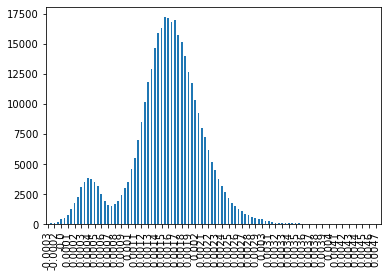

In [130]:
hist_plot = pd.Series({b_i:c_i for c_i, b_i in zip(c, b[:-1])})
hist_plot.plot(kind='bar')
plt.xticks(range(len(hist_plot))[::2], list(map(lambda x: round(x, 4), hist_plot.index))[::2]);

In [133]:
(inner_join_df
 .groupby(['entry_id_x', 'version_x', 'sent_idx_x', 'sent_idx_y', 'word_idx_x', 'token_x'])
 ['dot_product'].idxmax()
 .head(3)
)

entry_id_x  version_x  sent_idx_x  sent_idx_y  word_idx_x  token_x   
547989      0          0           0           0           WASHINGTON       0
                                               1           —              608
                                               2           Weapons       1216
Name: dot_product, dtype: int64

In [134]:
max_words = (inner_join_df
 .loc[lambda df: df.groupby(['entry_id_x', 'version_x', 'sent_idx_x', 'sent_idx_y', 'word_idx_x', 'token_x'])['dot_product'].idxmax()]
 [des_col_list]
 .groupby([
     'entry_id_x', 'version_x', 'sent_idx_x', 'version_y', 'sent_idx_y'
 ])['dot_product']
 .mean()
 .reset_index()
 .loc[lambda df: df.groupby(['entry_id_x', 'version_x', 'sent_idx_x', 'version_y'])['dot_product'].idxmax()]
 .sort_values('sent_idx_x')
#  .loc[lambda df: df['sent_idx_x'] != df['sent_idx_y']]
)

In [ ]:
num_sents = []
for entry_id, version, text in tqdm(df[['entry_id', 'version', 'summary']].itertuples(index=False), total=len(df)):
    num_sents.append({
        'entry_id': entry_id,
        'version': version,
        'num_sents': len(unp.split_sents(text))
    })

pd.concat([
    sent_dfp_dl.groupby(['entry_id', 'version']).apply(lambda df: len(df)).to_frame('dl'),
    sent_dfp_nondl.groupby(['entry_id', 'version']).apply(lambda df: len(df)).to_frame('nondl'),
    pd.DataFrame(num_sents).set_index(['entry_id', 'version'])['num_sents'].to_frame('spacy')
], axis=1).head()

In [ ]:
#                  CONCAT(word_emb.entry_id, '-', 
#                         word_emb.version, '-',
#                         word_emb_2.version, '-',
#                         word_emb.sent_idx, '-',
#                         word_emb_2.sent_idx, '-',
#                         word_emb.word_idx, '-',
#                         word_emb_2.word_idx, '-',
#                         word_emb.token, '-'
#                         )                                                            AS partition_key,